In [73]:
import pandas as pd
import numpy as np
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.express as px
import plotly.graph_objs as go

import torch
import torch.nn as nn

In [2]:
gender = pd.read_csv("gender.csv")
gender = gender.drop(['Unnamed: 0', 'School'], axis = 1)

eth = pd.read_csv("race.csv")
eth = eth.drop(['Unnamed: 0', 'School'], axis = 1).rename(columns = {'Uad Uc Ethn 6 Cat': 'Ethnicity'})

In [3]:
gender

,Calculation1,City,County/State/ Territory,Count,Gender,Pivot Field Values
0,21ST CENTURY EXPERIMENTAL SCH694223,NaN,NaN,App,Male,5
1,21ST CENTURY EXPERIMENTAL SCH694223,NaN,NaN,App,Female,6
2,21ST CENTURY EXPERIMENTAL SCH694223,NaN,NaN,App,All,11
3,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,App,Male,6
4,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,Adm,Female,4
5,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,Adm,All,6
6,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,App,All,11
7,A B MILLER HIGH SCHOOL50944,Fontana,San Bernardino,Adm,Male,3
8,A B MILLER HIGH SCHOOL50944,Fontana,San Bernardino,App,Male,6
9,A B MILLER HIGH SCHOOL50944,Fontana,San Bernardino,Adm,All,4


In [4]:
print(gender.head().to_latex())

\begin{tabular}{llllllr}
\toprule
{} &                          Calculation1 &             City & County/State/ Territory & Count &  Gender &  Pivot Field Values \\
\midrule
0 &   21ST CENTURY EXPERIMENTAL SCH694223 &              NaN &                     NaN &   App &    Male &                   5 \\
1 &   21ST CENTURY EXPERIMENTAL SCH694223 &              NaN &                     NaN &   App &  Female &                   6 \\
2 &   21ST CENTURY EXPERIMENTAL SCH694223 &              NaN &                     NaN &   App &     All &                  11 \\
3 &  A \& M CONSOLIDATED HIGH SCHOOL441400 &  College Station &                      TX &   App &    Male &                   6 \\
4 &  A \& M CONSOLIDATED HIGH SCHOOL441400 &  College Station &                      TX &   Adm &  Female &                   4 \\
\bottomrule
\end{tabular}



In [5]:
# features: proportion of applicants that were male
# proportion admitted male

# target: in state or not AND in state, out of state, international

In [6]:
# we need schools with both numbers for # of students applied and # of students admitted
# so we need to do some wranging to get that

In [7]:
gender_filtered = gender.groupby('Calculation1').filter(lambda df: len(df.loc[df['Count'] == 'Adm', 'Count']) > 0)

In [8]:
gender_filtered

,Calculation1,City,County/State/ Territory,Count,Gender,Pivot Field Values
3,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,App,Male,6
4,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,Adm,Female,4
5,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,Adm,All,6
6,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,App,All,11
7,A B MILLER HIGH SCHOOL50944,Fontana,San Bernardino,Adm,Male,3
8,A B MILLER HIGH SCHOOL50944,Fontana,San Bernardino,App,Male,6
9,A B MILLER HIGH SCHOOL50944,Fontana,San Bernardino,Adm,All,4
10,A B MILLER HIGH SCHOOL50944,Fontana,San Bernardino,App,All,13
11,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,Adm,Male,3
12,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,App,Male,52


In [9]:
# not all schools have numbers for all categories – we need to interpolate them for consistency

In [10]:
all_count, male_count, female_count = 0, 0, 0

In [11]:
for name, df in gender_filtered.groupby('Calculation1'):
    app = df.loc[df['Count'] == 'App', 'Gender']
    app = sorted(app.tolist())
    
    if app == ['All']:
        # No gender data
        pass
    
    if app == sorted(['All', 'Female', 'Male']):
#         print('has all')
        all_count += 1

    if app == ['All', 'Male']:
#         print(name)
        male_count += 1
    
    if app == ['All', 'Female']:
        female_count += 1
    
#     print(df)

In [12]:
# jk – the majority of schools do have all of that data, let's just work with them

In [13]:
gender_filtered = gender_filtered.groupby('Calculation1').filter(
    lambda df: (sorted(df.loc[df['Count'] == 'App', 'Gender'].tolist()) == ['All', 'Female', 'Male']) &
               (sorted(df.loc[df['Count'] == 'Adm', 'Gender'].tolist()) == ['All', 'Female', 'Male'])

)

In [14]:
gender_filtered

,Calculation1,City,County/State/ Territory,Count,Gender,Pivot Field Values
11,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,Adm,Male,3
12,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,App,Male,52
13,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,Enr,Female,6
14,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,Adm,Female,6
15,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,App,Female,57
16,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,Enr,All,7
17,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,Adm,All,9
18,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,App,All,109
37,ACADEMY OF THE CANYONS53262,Santa Clarita,Los Angeles,Adm,Male,4
38,ACADEMY OF THE CANYONS53262,Santa Clarita,Los Angeles,App,Male,14


In [15]:
df = pd.pivot_table(gender_filtered,
               index = 'Calculation1', 
               values = 'Pivot Field Values', 
               columns = ['Count', 'Gender'])[['App', 'Adm']]

In [16]:
df

Count                                   App                 Adm             
Gender                                  All Female   Male   All Female  Male
Calculation1                                                                
ABRAHAM LINCOLN HIGH SCHOOL52910      109.0   57.0   52.0   9.0    6.0   3.0
ACADEMY OF THE CANYONS53262            34.0   20.0   14.0   9.0    5.0   4.0
ACALANES HIGH SCHOOL51315              80.0   44.0   36.0  10.0    5.0   5.0
ADLAI E STEVENSON HIGH SCHOOL143550    76.0   29.0   47.0  11.0    3.0   8.0
ADOLFO CAMARILLO HIGH SCHOOL50438      47.0   21.0   26.0   8.0    4.0   4.0
ADRIAN C WILCOX HIGH SCHOOL53276       66.0   40.0   26.0  14.0   10.0   4.0
AGOURA HIGH SCHOOL50003                70.0   32.0   38.0  11.0    5.0   6.0
ALAMEDA SCIENCE & TECHLGY INST50029    29.0   11.0   18.0   8.0    3.0   5.0
ALBANY HIGH SCHOOL50035                91.0   48.0   43.0  25.0   15.0  10.0
ALEXANDER HAMILTON HIGH SCHOOL51525    92.0   53.0   39.0  17.0   10.0   7.0
ALISO NIGUEL HIGH SCHOOL51324         113.0   52.0   61.0  19.0    9.0  10.0
AMADOR VALLEY HIGH SCHOOL52495        213.0  102.0  111.0  56.0   25.0  31.0
AMERICAN HERITAGE SCHOOL101422         37.0   15.0   22.0   8.0    3.0   5.0
AMERICAN HIGH SCHOOL50974             202.0  106.0   95.0  32.0   17.0  15.0
ANGELO RODRIGUEZ HIGH SCHOOL50919      53.0   38.0   15.0  15.0    9.0   6.0
ANTELOPE HIGH SCHOOL54250              30.0   18.0   11.0   6.0    3.0   3.0
ARAGON HIGH SCHOOL53163               105.0   46.0   59.0  22.0   15.0   7.0
ARCADIA HIGH SCHOOL50130              284.0  152.0  131.0  56.0   34.0  22.0
ARCHBISHOP MITTY HIGH SCHOOL53078     156.0   79.0   77.0  34.0   25.0   9.0
ARMIJO HIGH SCHOOL50910                42.0   19.0   23.0   8.0    4.0   4.0
ARNOLD O BECKMAN HIGH SCHOOL51267     206.0  101.0  105.0  45.0   27.0  18.0
ARROYO GRANDE HIGH SCHOOL50150         47.0   24.0   23.0   8.0    4.0   4.0
ARROYO HIGH SCHOOL50830                35.0   20.0   15.0   8.0    5.0   3.0
ARROYO HIGH SCHOOL53125                66.0   39.0   27.0  12.0    7.0   5.0
BASIS CHANDLER30072                    21.0    8.0   12.0   8.0    4.0   3.0
BASIS INDEPENDENT SILICON VLY54776     95.0   42.0   53.0  33.0   14.0  19.0
BASIS SCOTTSDALE CHARTER SCH30660      27.0    9.0   18.0   7.0    4.0   3.0
BEIJING NATIONAL DAY SCHOOL694342      98.0   49.0   49.0   8.0    5.0   3.0
BELL GARDENS SENIOR HS50265            30.0   18.0   12.0   8.0    5.0   3.0
BELL HIGH SCHOOL50245                  58.0   30.0   28.0  14.0   10.0   4.0
...                                     ...    ...    ...   ...    ...   ...
VALLEY HIGH SCHOOL53243                39.0   21.0   18.0  10.0    6.0   4.0
VAN NUYS HIGH SCHOOL53635              83.0   48.0   34.0  19.0   11.0   8.0
VENICE HIGH SCHOOL51828                59.0   34.0   25.0  13.0    9.0   4.0
VIEWPOINT SCHOOL50423                  57.0   31.0   26.0  20.0   11.0   9.0
VILLAGE CHRISTIAN HIGH SCHOOL53468     27.0    7.0   20.0  10.0    5.0   5.0
VISTA DEL LAGO HIGH SCHOOL54166        65.0   33.0   31.0  22.0   12.0   9.0
WALNUT HIGH SCHOOL53676               202.0  103.0   99.0  47.0   29.0  18.0
WALTER JOHNSON HIGH SCHOOL210912       27.0   17.0    9.0   8.0    5.0   3.0
WASHINGTON HIGH SCHOOL50972           101.0   50.0   51.0  17.0    9.0   8.0
WAYZATA HIGH SCHOOL242650              38.0   20.0   17.0  11.0    6.0   5.0
WEST CAMPUS HIGH SCHOOL52728           49.0   18.0   31.0   6.0    3.0   3.0
WEST COVINA HIGH SCHOOL53738           48.0   24.0   24.0  14.0    8.0   6.0
WEST HIGH SCHOOL450400                 30.0   18.0   12.0   9.0    6.0   3.0
WEST HIGH SCHOOL53521                  76.0   34.0   42.0  19.0    7.0  12.0
WEST RANCH HIGH SCHOOL53864           115.0   70.0   45.0  27.0   20.0   7.0
WESTLAKE HIGH SCHOOL440324             37.0   18.0   18.0  10.0    7.0   3.0
WESTLAKE HIGH SCHOOL53503             117.0   70.0   47.0  34.0   24.0  10.0
WESTMONT HIGH SCHOOL53103              51.0   30.0   21.0  11.0    6.0   

In [17]:
df['AppMaleProportion'] = df[('App', 'Male')] / df[('App', 'All')]
df['AdmMaleProportion'] = df[('Adm', 'Male')] / df[('Adm', 'All')]

In [18]:
# https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
df.columns = [''.join(col).strip() for col in df.columns.values]

In [19]:
df

,AppAll,AppFemale,AppMale,AdmAll,AdmFemale,AdmMale,AppMaleProportion,AdmMaleProportion
Calculation1,,,,,,,,
ABRAHAM LINCOLN HIGH SCHOOL52910,109.0,57.0,52.0,9.0,6.0,3.0,0.477064,0.333333
ACADEMY OF THE CANYONS53262,34.0,20.0,14.0,9.0,5.0,4.0,0.411765,0.444444
ACALANES HIGH SCHOOL51315,80.0,44.0,36.0,10.0,5.0,5.0,0.450000,0.500000
ADLAI E STEVENSON HIGH SCHOOL143550,76.0,29.0,47.0,11.0,3.0,8.0,0.618421,0.727273
ADOLFO CAMARILLO HIGH SCHOOL50438,47.0,21.0,26.0,8.0,4.0,4.0,0.553191,0.500000
ADRIAN C WILCOX HIGH SCHOOL53276,66.0,40.0,26.0,14.0,10.0,4.0,0.393939,0.285714
AGOURA HIGH SCHOOL50003,70.0,32.0,38.0,11.0,5.0,6.0,0.542857,0.545455
ALAMEDA SCIENCE & TECHLGY INST50029,29.0,11.0,18.0,8.0,3.0,5.0,0.620690,0.625000
ALBANY HIGH SCHOOL50035,91.0,48.0,43.0,25.0,15.0,10.0,0.472527,0.400000


In [20]:
# getting whether or not the school is in state

In [21]:
# international
gender_filtered.loc[gender_filtered['County/State/ Territory'].isnull(), 'Location'] = 'INT'
gender_filtered.loc[gender_filtered['County/State/ Territory'].str.len() == 2, 'Location'] = 'OOS'
gender_filtered.loc[gender_filtered['County/State/ Territory'].str.len() > 2, 'Location'] = 'INS'

/Users/sukritarora/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/sukritarora/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [22]:
df = df.merge(gender_filtered[['Calculation1', 'Location']].groupby('Calculation1').agg(lambda x: x.iloc[0])
         , on = 'Calculation1')

In [23]:
df

,AppAll,AppFemale,AppMale,AdmAll,AdmFemale,AdmMale,AppMaleProportion,AdmMaleProportion,Location
Calculation1,,,,,,,,,
ABRAHAM LINCOLN HIGH SCHOOL52910,109.0,57.0,52.0,9.0,6.0,3.0,0.477064,0.333333,INS
ACADEMY OF THE CANYONS53262,34.0,20.0,14.0,9.0,5.0,4.0,0.411765,0.444444,INS
ACALANES HIGH SCHOOL51315,80.0,44.0,36.0,10.0,5.0,5.0,0.450000,0.500000,INS
ADLAI E STEVENSON HIGH SCHOOL143550,76.0,29.0,47.0,11.0,3.0,8.0,0.618421,0.727273,OOS
ADOLFO CAMARILLO HIGH SCHOOL50438,47.0,21.0,26.0,8.0,4.0,4.0,0.553191,0.500000,INS
ADRIAN C WILCOX HIGH SCHOOL53276,66.0,40.0,26.0,14.0,10.0,4.0,0.393939,0.285714,INS
AGOURA HIGH SCHOOL50003,70.0,32.0,38.0,11.0,5.0,6.0,0.542857,0.545455,INS
ALAMEDA SCIENCE & TECHLGY INST50029,29.0,11.0,18.0,8.0,3.0,5.0,0.620690,0.625000,INS
ALBANY HIGH SCHOOL50035,91.0,48.0,43.0,25.0,15.0,10.0,0.472527,0.400000,INS


In [24]:
# now we need to repeat the above filtering for ethnicity, join the two, and then start classifying stuff
# for simplicity, we just need the 'white' proportion

In [25]:
eth

,Calculation1,City,County/State/ Territory,Count,Ethnicity,Pivot Field Values
0,21ST CENTURY EXPERIMENTAL SCH694223,NaN,NaN,App,All,11
1,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,Adm,Asian,4
2,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,App,Asian,8
3,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,Adm,All,6
4,A & M CONSOLIDATED HIGH SCHOOL441400,College Station,TX,App,All,11
5,A B MILLER HIGH SCHOOL50944,Fontana,San Bernardino,App,Hispanic/ Latino,9
6,A B MILLER HIGH SCHOOL50944,Fontana,San Bernardino,Adm,All,4
7,A B MILLER HIGH SCHOOL50944,Fontana,San Bernardino,App,All,13
8,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,App,White,6
9,ABRAHAM LINCOLN HIGH SCHOOL52910,San Francisco,San Francisco,Enr,Asian,6


In [26]:
eth_filtered = eth.groupby('Calculation1').filter(lambda df: len(df.loc[df['Count'] == 'Adm', 'Count']) > 0)
eth_filtered = eth_filtered.groupby('Calculation1').filter(
    lambda df: ('White' in df.loc[df['Count'] == 'App', 'Ethnicity'].tolist()) &
               ('All' in df.loc[df['Count'] == 'App', 'Ethnicity'].tolist()) &
               ('White' in df.loc[df['Count'] == 'Adm', 'Ethnicity'].tolist()) &
               ('All' in df.loc[df['Count'] == 'Adm', 'Ethnicity'].tolist())
)

eth_filtered.loc[eth_filtered['County/State/ Territory'].isnull(), 'Location'] = 'INT'
eth_filtered.loc[eth_filtered['County/State/ Territory'].str.len() == 2, 'Location'] = 'OOS'
eth_filtered.loc[eth_filtered['County/State/ Territory'].str.len() > 2, 'Location'] = 'INS'

df_eth = pd.pivot_table(eth_filtered,
               index = 'Calculation1', 
               values = 'Pivot Field Values', 
               columns = ['Count', 'Ethnicity'])[['App', 'Adm']]

df_eth['AppWhiteProportion'] = df_eth[('App', 'White')] / df_eth[('App', 'All')]
df_eth['AdmWhiteProportion'] = df_eth[('Adm', 'White')] / df_eth[('Adm', 'All')]

df_eth.columns = [''.join(col).strip() for col in df_eth.columns.values]

df_eth = df_eth[['AppWhiteProportion', 'AdmWhiteProportion']]

df_eth = df_eth.merge(eth_filtered[['Calculation1', 'Location']].groupby('Calculation1').agg(lambda x: x.iloc[0])
         , on = 'Calculation1')

In [27]:
# turns out no schools both reported white/all proportions AND male/female/all proportions, so these analyses need to be done separately

In [28]:
df

,AppAll,AppFemale,AppMale,AdmAll,AdmFemale,AdmMale,AppMaleProportion,AdmMaleProportion,Location
Calculation1,,,,,,,,,
ABRAHAM LINCOLN HIGH SCHOOL52910,109.0,57.0,52.0,9.0,6.0,3.0,0.477064,0.333333,INS
ACADEMY OF THE CANYONS53262,34.0,20.0,14.0,9.0,5.0,4.0,0.411765,0.444444,INS
ACALANES HIGH SCHOOL51315,80.0,44.0,36.0,10.0,5.0,5.0,0.450000,0.500000,INS
ADLAI E STEVENSON HIGH SCHOOL143550,76.0,29.0,47.0,11.0,3.0,8.0,0.618421,0.727273,OOS
ADOLFO CAMARILLO HIGH SCHOOL50438,47.0,21.0,26.0,8.0,4.0,4.0,0.553191,0.500000,INS
ADRIAN C WILCOX HIGH SCHOOL53276,66.0,40.0,26.0,14.0,10.0,4.0,0.393939,0.285714,INS
AGOURA HIGH SCHOOL50003,70.0,32.0,38.0,11.0,5.0,6.0,0.542857,0.545455,INS
ALAMEDA SCIENCE & TECHLGY INST50029,29.0,11.0,18.0,8.0,3.0,5.0,0.620690,0.625000,INS
ALBANY HIGH SCHOOL50035,91.0,48.0,43.0,25.0,15.0,10.0,0.472527,0.400000,INS


### actual machine learning

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [30]:
df.head()

,AppAll,AppFemale,AppMale,AdmAll,AdmFemale,AdmMale,AppMaleProportion,AdmMaleProportion,Location
Calculation1,,,,,,,,,
ABRAHAM LINCOLN HIGH SCHOOL52910,109.0,57.0,52.0,9.0,6.0,3.0,0.477064,0.333333,INS
ACADEMY OF THE CANYONS53262,34.0,20.0,14.0,9.0,5.0,4.0,0.411765,0.444444,INS
ACALANES HIGH SCHOOL51315,80.0,44.0,36.0,10.0,5.0,5.0,0.450000,0.500000,INS
ADLAI E STEVENSON HIGH SCHOOL143550,76.0,29.0,47.0,11.0,3.0,8.0,0.618421,0.727273,OOS
ADOLFO CAMARILLO HIGH SCHOOL50438,47.0,21.0,26.0,8.0,4.0,4.0,0.553191,0.500000,INS


In [31]:
df['binary target'] = 1 * (df['Location'] == 'INS')

In [32]:
df['Location'].value_counts()

INS    318
OOS     49
INT     29
Name: Location, dtype: int64

In [33]:
df['binary target'].value_counts()

1    318
0     78
Name: binary target, dtype: int64

In [34]:
train_binary, test_binary = train_test_split(df, test_size = 0.2, random_state = 42)

In [35]:
binary_models = {
    'lr': LogisticRegression(),
    'lrb': LogisticRegression(class_weight = "balanced"),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier()
}

lr 0.8037974683544303 0.8
[1]


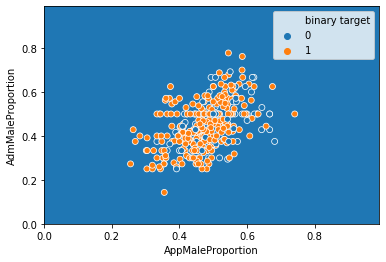

lrb 0.6170886075949367 0.6625
[0 1]


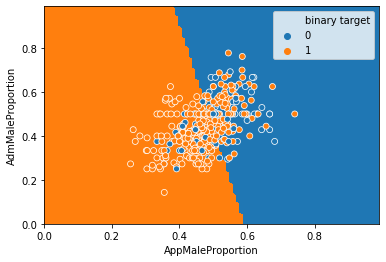

dt 0.9936708860759493 0.6875
[0 1]


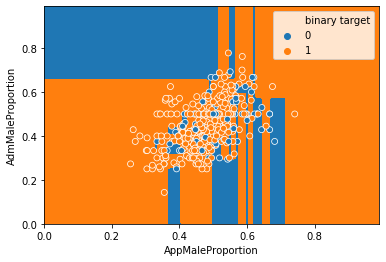

rf 0.9936708860759493 0.75
[0 1]


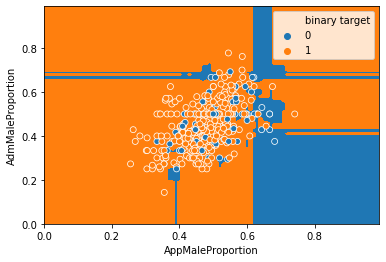

In [36]:
for m in binary_models:
    binary_models[m].fit(train_binary[['AppMaleProportion', 'AdmMaleProportion']], train_binary['binary target'])
    train_acc = binary_models[m].score(train_binary[['AppMaleProportion', 'AdmMaleProportion']], train_binary['binary target'])
    test_acc = binary_models[m].score(test_binary[['AppMaleProportion', 'AdmMaleProportion']], test_binary['binary target'])
    print(m, train_acc, test_acc)
    
    sns_cmap = ListedColormap(np.array(sns.color_palette())[0:2, :])

    xx, yy = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
    Z_string = binary_models[m].predict(np.c_[xx.ravel(), yy.ravel()])
    categories, Z_int = np.unique(Z_string, return_inverse = True)
    Z_int = Z_int.reshape(xx.shape)
    print(categories)
    plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
    sns.scatterplot(data = train_binary, x = 'AppMaleProportion', y = 'AdmMaleProportion', hue = 'binary target', cmap = sns_cmap)
#     plt.title('Logistic Regression on nba_train');
#     break
    plt.show()
    

In [37]:
binary_models['dt'].predict(train_binary[['AppMaleProportion', 'AdmMaleProportion']])

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,

In [38]:
# merged data

In [39]:
df_merged = df.merge(df_eth, left_index = True, right_index = True)[['AppMaleProportion', 'AdmMaleProportion',
                                                       'AppWhiteProportion', 'AdmWhiteProportion',
                                                       'Location_x', 'binary target']].rename(
                                                        columns = {'Location_x': 'Location'})
df_merged

,AppMaleProportion,AdmMaleProportion,AppWhiteProportion,AdmWhiteProportion,Location,binary target
Calculation1,,,,,,
ACALANES HIGH SCHOOL51315,0.450000,0.500000,0.675000,0.600000,INS,1
ADOLFO CAMARILLO HIGH SCHOOL50438,0.553191,0.500000,0.191489,0.375000,INS,1
ADRIAN C WILCOX HIGH SCHOOL53276,0.393939,0.285714,0.196970,0.285714,INS,1
AGOURA HIGH SCHOOL50003,0.542857,0.545455,0.585714,0.454545,INS,1
ALAMEDA SCIENCE & TECHLGY INST50029,0.620690,0.625000,0.206897,0.375000,INS,1
ALBANY HIGH SCHOOL50035,0.472527,0.400000,0.219780,0.320000,INS,1
ALEXANDER HAMILTON HIGH SCHOOL51525,0.423913,0.411765,0.271739,0.411765,INS,1
ALISO NIGUEL HIGH SCHOOL51324,0.539823,0.526316,0.469027,0.473684,INS,1
AMADOR VALLEY HIGH SCHOOL52495,0.521127,0.553571,0.215962,0.071429,INS,1


In [40]:
df_merged.corr()

,AppMaleProportion,AdmMaleProportion,AppWhiteProportion,AdmWhiteProportion,binary target
AppMaleProportion,1.000000,0.514663,0.001233,-0.123277,-0.085253
AdmMaleProportion,0.514663,1.000000,0.122050,0.067881,-0.096873
AppWhiteProportion,0.001233,0.122050,1.000000,0.761913,-0.044211
AdmWhiteProportion,-0.123277,0.067881,0.761913,1.000000,-0.061124
binary target,-0.085253,-0.096873,-0.044211,-0.061124,1.000000


In [41]:
train_merged, test_merged = train_test_split(df_merged, test_size = 0.2, random_state = 6)

In [42]:
binary_models_merged = {
    'lr': LogisticRegression(),
    'lrb': LogisticRegression(class_weight = "balanced"),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier()
}

In [43]:
features = ['AppMaleProportion', 'AdmMaleProportion', 'AppWhiteProportion', 'AdmWhiteProportion']

In [44]:
for m in binary_models_merged:
    binary_models_merged[m].fit(train_merged[features], train_merged['binary target'])
    train_acc = binary_models_merged[m].score(train_merged[features], train_merged['binary target'])
    test_acc = binary_models_merged[m].score(test_merged[features], test_merged['binary target'])
    print(m, train_acc, test_acc)
    
    # could add in precision and recall
    

lr 0.9006622516556292 0.9473684210526315
lrb 0.5761589403973509 0.631578947368421
dt 1.0 0.8947368421052632
rf 1.0 0.9473684210526315


In [45]:
# roc curve of binary logistic regression model

In [46]:
from sklearn.metrics import roc_curve

In [47]:
fpr, tpr, threshold = roc_curve(train_merged['binary target'], 
                               binary_models_merged['lr'].predict_proba(train_merged[features])[:, 1])

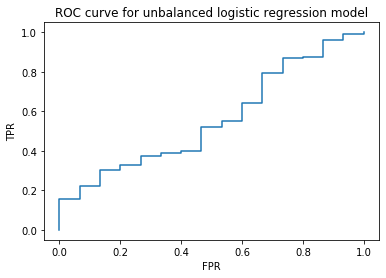

In [48]:
plt.plot(fpr, tpr);
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for unbalanced logistic regression model');

In [49]:
fpr, tpr, threshold = roc_curve(train_merged['binary target'], 
                               binary_models_merged['lrb'].predict_proba(train_merged[features])[:, 1])

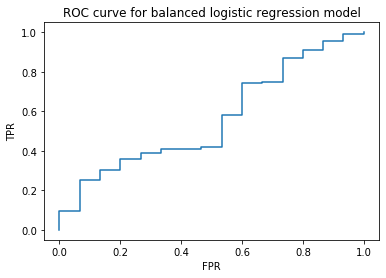

In [50]:
plt.plot(fpr, tpr);
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for balanced logistic regression model');

In [51]:
binary_models['lrb'].coef_

array([[-2.33117978, -0.49304826]])

In [52]:
binary_models_merged['lrb'].coef_

array([[-0.68676338, -0.36403107, -0.10766983, -0.38821054]])

### fairness criterion

In [53]:
Y = train_merged['binary target']
A = train_merged[features]
R = binary_models_merged['lrb'].predict(train_merged[features])#[:, 1]

In [54]:
# clearly these are garbage, pretty close to random model (0.5)
# only classifying well because of the severe class imbalance

In [55]:
# plan: make A the category for whether or not a majority of applicants were male (or accepted)
# then look at separation and sufficiency

In [56]:
A = train_merged['AppMaleProportion'] >= 0.5

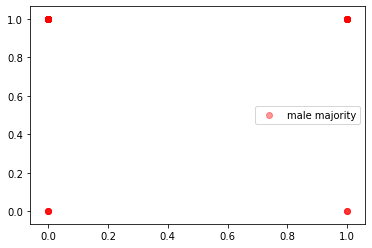

In [57]:
plt.scatter(R[A], Y[A], label = 'male majority', alpha = 0.4, color = 'r');
# plt.scatter(R[~A], Y[~A], label = 'female majority', alpha = 0.4);
plt.legend();

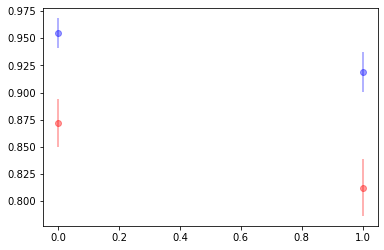

In [58]:
plt.errorbar([0], [np.mean(Y[A][R[A] == 0])], color = 'red', alpha = 0.4, label = 'male',
            yerr=np.std(Y[A][R[A] == 0]) / 15, fmt='o') 
plt.errorbar([1], [np.mean(Y[A][R[A] == 1])], color = 'red', alpha = 0.4, label = 'male',
            yerr=np.std(Y[A][R[A] == 1]) / 15, fmt='o')

plt.errorbar([0], [np.mean(Y[~A][R[~A] == 0])], color = 'blue', alpha = 0.4, label = 'female',
            yerr=np.std(Y[~A][R[~A] == 0]) / 15, fmt='o')
plt.errorbar([1], [np.mean(Y[~A][R[~A] == 1])], color = 'blue', alpha = 0.4, label = 'female',
            yerr=np.std(Y[~A][R[~A] == 1]) / 15, fmt='o');

In [59]:
np.mean(Y[~A][R[~A] == 1])

0.918918918918919

In [60]:
np.mean(Y[~A][R[~A] == 0])

0.9545454545454546

In [61]:
# out of state schools have more female applicants??? 

## Regression models

In [62]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor

In [63]:
# given all other features, predict AdmWhiteProportion

In [64]:
df_ohe = pd.get_dummies(df_merged, columns = ['Location']) \
.drop(['binary target', 'Location_INS'], axis = 1) \
.rename(columns = {'AdmWhiteProportion': 'TargetProportion'}) \
.iloc[:, [0, 1, 2, 4, 5, 3]]

In [65]:
df_ohe

,AppMaleProportion,AdmMaleProportion,AppWhiteProportion,Location_INT,Location_OOS,TargetProportion
Calculation1,,,,,,
ACALANES HIGH SCHOOL51315,0.450000,0.500000,0.675000,0,0,0.600000
ADOLFO CAMARILLO HIGH SCHOOL50438,0.553191,0.500000,0.191489,0,0,0.375000
ADRIAN C WILCOX HIGH SCHOOL53276,0.393939,0.285714,0.196970,0,0,0.285714
AGOURA HIGH SCHOOL50003,0.542857,0.545455,0.585714,0,0,0.454545
ALAMEDA SCIENCE & TECHLGY INST50029,0.620690,0.625000,0.206897,0,0,0.375000
ALBANY HIGH SCHOOL50035,0.472527,0.400000,0.219780,0,0,0.320000
ALEXANDER HAMILTON HIGH SCHOOL51525,0.423913,0.411765,0.271739,0,0,0.411765
ALISO NIGUEL HIGH SCHOOL51324,0.539823,0.526316,0.469027,0,0,0.473684
AMADOR VALLEY HIGH SCHOOL52495,0.521127,0.553571,0.215962,0,0,0.071429


In [66]:
train_ohe, test_ohe = train_test_split(df_ohe, test_size = 0.2, random_state = 17)

In [67]:
regression_models = {
    'ols': LinearRegression(),
    'ridge': Ridge(),
    'ridgecv': RidgeCV(),
    'lasso': Lasso(),
    'lassocv': LassoCV(),
    'knn': KNeighborsRegressor()
}

In [68]:
for m in regression_models:
    regression_models[m].fit(train_ohe.iloc[:, :-1], train_ohe.iloc[:, -1])
    train_rmse = np.mean((regression_models[m].predict(train_ohe.iloc[:, :-1]) - train_ohe.iloc[:, -1])**2)
    test_rmse = np.mean((regression_models[m].predict(test_ohe.iloc[:, :-1]) - test_ohe.iloc[:, -1])**2)
    if m == 'knn':
        print(m, train_rmse, test_rmse)
    else:
        print(f"{m}, {np.round(train_rmse, 3)}, {np.round(test_rmse, 3)}, {np.round(regression_models[m].coef_, 3)}, {np.round(regression_models[m].intercept_, 3)}")
    

ols, 0.015, 0.023, [-0.433  0.131  0.964  0.021  0.032], 0.182
ridge, 0.016, 0.023, [-0.156  0.053  0.771 -0.028  0.033], 0.161
ridgecv, 0.015, 0.023, [-0.368  0.109  0.94   0.007  0.032], 0.171
lasso, 0.041, 0.04, [-0.  0.  0. -0.  0.], 0.408
lassocv, 0.016, 0.023, [-0.     0.     0.876 -0.     0.   ], 0.074
knn 0.01230504511971793 0.02657491773168908


In [69]:
train_ohe.iloc[:, -1].mean()

0.4076123949983847

In [70]:
regression_models['lasso'].predict(train_ohe.iloc[:, :-1])

array([0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761239,
       0.40761239, 0.40761239, 0.40761239, 0.40761239, 0.40761

In [71]:
df_ohe

,AppMaleProportion,AdmMaleProportion,AppWhiteProportion,Location_INT,Location_OOS,TargetProportion
Calculation1,,,,,,
ACALANES HIGH SCHOOL51315,0.450000,0.500000,0.675000,0,0,0.600000
ADOLFO CAMARILLO HIGH SCHOOL50438,0.553191,0.500000,0.191489,0,0,0.375000
ADRIAN C WILCOX HIGH SCHOOL53276,0.393939,0.285714,0.196970,0,0,0.285714
AGOURA HIGH SCHOOL50003,0.542857,0.545455,0.585714,0,0,0.454545
ALAMEDA SCIENCE & TECHLGY INST50029,0.620690,0.625000,0.206897,0,0,0.375000
ALBANY HIGH SCHOOL50035,0.472527,0.400000,0.219780,0,0,0.320000
ALEXANDER HAMILTON HIGH SCHOOL51525,0.423913,0.411765,0.271739,0,0,0.411765
ALISO NIGUEL HIGH SCHOOL51324,0.539823,0.526316,0.469027,0,0,0.473684
AMADOR VALLEY HIGH SCHOOL52495,0.521127,0.553571,0.215962,0,0,0.071429


In [72]:
train_merged

,AppMaleProportion,AdmMaleProportion,AppWhiteProportion,AdmWhiteProportion,Location,binary target
Calculation1,,,,,,
SAGE HILL SCHOOL52124,0.536232,0.565217,0.449275,0.347826,INS,1
REDWOOD HIGH SCHOOL51361,0.488000,0.473684,0.648000,0.736842,INS,1
MALIBU HIGH SCHOOL51896,0.558140,0.375000,0.697674,0.375000,INS,1
JOHN BURROUGHS HIGH SCHOOL50400,0.515152,0.500000,0.409091,0.300000,INS,1
DESERT VISTA HIGH SCHOOL30328,0.500000,0.625000,0.611111,0.750000,OOS,0
OAKS CHRISTIAN SCHOOL53746,0.400000,0.571429,0.400000,0.571429,INS,1
CHADWICK SCHOOL52680,0.475000,0.583333,0.325000,0.333333,INS,1
NUEVA SCHOOL51213,0.605263,0.636364,0.421053,0.454545,INS,1
PHILLIPS EXETER ACADEMY300185,0.470588,0.500000,0.294118,0.300000,OOS,0


## PyTorch Code

In [95]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [454]:
class NNClassifier(nn.Module):
    def __init__(self, in_feat, hidden_dims=(1000, 500), extra_layer=False):
        super().__init__()
        self.extra_layer = extra_layer
        self.fc1 = nn.Linear(in_feat, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[1])
        self.fc4 = nn.Linear(hidden_dims[1], 2)
        
    def forward(self, x):
        l1_out = nn.functional.relu(self.fc1(x))
        l2_out = nn.functional.relu(self.fc2(l1_out))
        l3_out = nn.functional.relu(self.fc3(l2_out)) if self.extra_layer else l2_out
        out = self.fc4(l3_out)
        return out
    
class NNRegressor(nn.Module):
    def __init__(self, in_feat, hidden_dims=(50, 25), extra_layer=False):
        super().__init__()
        self.extra_layer = extra_layer
        self.fc1 = nn.Linear(in_feat, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[1])
        self.fc4 = nn.Linear(hidden_dims[1], 1)
        
    def forward(self, x):
        l1_out = nn.functional.relu(self.fc1(x))
        l2_out = nn.functional.relu(self.fc2(l1_out))
        l3_out = nn.functional.relu(self.fc3(l2_out)) if self.extra_layer else l2_out
        out = self.fc4(l3_out)
        return out

In [473]:
test_ohe.iloc[:, -1].values[:,None].shape

(38, 1)

In [491]:
# Converting the DataFrame to a DataLoader
def df_to_torch(data, target, batch_size=5, classify=True):
    if classify:
        target = torch.tensor(target.values.astype(np.long))
    else:
        target = torch.tensor(target.values[:,None].astype(np.float32))
    data = torch.tensor(data.values.astype(np.float32)) 
    data_tensor = TensorDataset(data, target) 
    data_loader = DataLoader(dataset = data_tensor, batch_size = batch_size, shuffle = True)
    return data_loader

# 2 Feature Classifier Data
classify = True
train_data = train_binary[['AppMaleProportion', 'AdmMaleProportion']]
train_target = train_binary['binary target']
test_data = test_binary[['AppMaleProportion', 'AdmMaleProportion']]
test_target = test_binary['binary target']

# 4 Feature Classifier Data
classify = True
# train_data = train_merged[features]
# train_target = train_merged['binary target']
# test_data = test_merged[features]
# test_target = test_merged['binary target']

# 4 Feature Regression
classify = False
train_data = train_ohe.iloc[:, :-1]
train_target = train_ohe.iloc[:, -1]
test_data = test_ohe.iloc[:, :-1]
test_target = test_ohe.iloc[:, -1]

train_loader = df_to_torch(train_data, train_target, classify=classify)
test_loader = df_to_torch(test_data, test_target, classify=classify)

In [492]:
num_pos = sum(train_target.values)
total = len(train_target.values)
num_neg = total-num_pos
weights = torch.tensor([num_neg, num_pos]).type(torch.float)/total
weights

tensor([0.5924, 0.4076])

In [493]:
# Create NN
# net = NNClassifier(2, hidden_dims=(50, 25))
# net = NNClassifier(4, hidden_dims=(1000, 500), extra_layer=True)
net = NNRegressor(5)

In [494]:
net

NNRegressor(
  (fc1): Linear(in_features=5, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=1, bias=True)
)

In [495]:
# Training
# criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=weights)
criterion = nn.MSELoss(reduction="sum")
# optimizer = optim.SGD(net.parameters(), 0.1)
optimizer = optim.Adam(net.parameters(),lr=0.001)
n_epochs = 200

for epoch in range(n_epochs):
    running_loss = 0
    for (data, target) in train_loader:
        optimizer.zero_grad()
        out = net(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()    # Does the update
        
        running_loss += loss.item()
    if epoch % 10 == 0:
        print("Epoch {}, Loss: {}".format(epoch+1, running_loss/total))

Epoch 1, Loss: 0.1006567905848192
Epoch 11, Loss: 0.0156261520583602
Epoch 21, Loss: 0.01521838413218394
Epoch 31, Loss: 0.01452255103118804
Epoch 41, Loss: 0.015268035115063536
Epoch 51, Loss: 0.014152652516171631
Epoch 61, Loss: 0.014595284953170659
Epoch 71, Loss: 0.014427417796721916
Epoch 81, Loss: 0.01363973788275624
Epoch 91, Loss: 0.013465841611097906
Epoch 101, Loss: 0.0143012779622974
Epoch 111, Loss: 0.015136405443217581
Epoch 121, Loss: 0.014267155345504648
Epoch 131, Loss: 0.01316046141495077
Epoch 141, Loss: 0.01319033232832093
Epoch 151, Loss: 0.013157274641886058
Epoch 161, Loss: 0.01369598977455086
Epoch 171, Loss: 0.012955125057391378
Epoch 181, Loss: 0.013160852935350294
Epoch 191, Loss: 0.012930691003219674


In [451]:
# Calculate Training Accuracy
with torch.no_grad():
        total = 0
        correct = 0
        for i, (data, target) in enumerate(train_loader):
            outputs = net(data)
            _, predicted = torch.max(outputs.data, 1)
#             print(predicted)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        train_acc = correct/total*100
print("Training Accuracy: {:.2f}".format(train_acc))

Training Accuracy: 80.38


In [452]:
# Calculate Testing Accuracy
with torch.no_grad():
        total = 0
        correct = 0
        for i, (data, target) in enumerate(test_loader):
            outputs = net(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        test_acc = correct/total*100
print("Test Accuracy: {:.2f}".format(test_acc))

Test Accuracy: 80.00


In [507]:
# Calculate Regression Test MSE
with torch.no_grad():
    loss = 0
    total = 0
    for i, (data, target) in enumerate(test_loader):
        loss += sum(((net(data)-target)**2))
        total += data.size(0)
    loss /= total
print("Test MSE: {:.4f}".format(loss.data.numpy()[0]))

Test MSE: 0.0221
